# Anger Camera SPICE-Integrated Data Reduction Script
***

This reduction and analysis notebook was created for the HFIR cycle 503 spin-energy entanglement experiment with the IU Rf flippers: 8/29 - 9/22 (2023) at CG4B.

## Defining various useful functions and constants

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from os.path import isdir,isfile
import warnings
from datetime import datetime
import matplotlib.dates as dates

laptop_direct = "C:/Users/samck/Desktop/Steve/New folder/"  #where the data is
desktop_direct = "C:/Users/xsm/Desktop/MIEZE_data/"
home_direct = "C:/Users/samck/Desktop/MIEZE_data/"

DEFAULT_DIRECT = laptop_direct  #can also be changed in function calls
DEFAULT_SPICE_LOG_DIRECT = "C:/Users/samck/Desktop/MIEZE context/"

assert isdir(DEFAULT_DIRECT), 'Default directory is not found!'
print(f'Default directory: {DEFAULT_DIRECT}')
assert isdir(DEFAULT_SPICE_LOG_DIRECT), 'Default SpICE log directory is not found!'
print(f'Default spice log directory: {DEFAULT_SPICE_LOG_DIRECT}')

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 20,25,35
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)

pixels_to_mm = 116./512.  #0.227 mm per pixel in Anger camera
CL = -4.63  #larmor constant (in Gauss and Angstroms)
LAM = 5.5  #CG4B wavelength (0.1% delta lambda)

def cos(x,amp,freq,phase,shim,offset):
    """Returns a cosine with ampitude, frequency, phase, shim, and offset."""
    return amp*np.cos(freq*(x - offset) + phase) + shim

def get_flip(dist,gpa,lam=LAM,flip=np.pi,show=True):
    """Returns the current required for pi or pi/2 flip."""
    result = round(flip/(CL*gpa*lam*dist*1e-2),2)
    if show: print(f'Current required for a {round(flip,2)} flip: {result} amps')
    return result

def frp_convert(value,show=False):
    """Convert polarization to flipping ratio and vice-versa."""
    assert value != 1, 'FR is infinite when polarization is unity!'
    if value > 1:
        result = (value - 1)/(value + 1)
        something = f'FR: {round(value,3)} \n Pol: {round(result*100,1)}%'
    else:
        result = (1 + value)/(1 - value)
        something = f'FR: {round(result,3)} \n Pol: {round(value*100,1)}%'
    if show: print(something)
    return result

def get_res(D,Ls,Ld,show=True):
    """Calculates geometric resolution."""
    res = D*Ls/Ld
    if show: print(f'Geometric resolution: {round(res,3)} (mm) \n')
    return res

def get_tof_pol(tof,ROI_x=(0,10),ROI_y=(0,10),plot=False):
    """Returns the polarization from a tof signal."""
    N = np.shape(tof)[1:]
    assert ROI_x[0] < ROI_x[1] < N[0], 'Check x-component of ROI.'
    assert ROI_y[0] < ROI_y[1] < N[1], 'Check y-component of ROI.'
    
    try: trimmed = np.sum(tof[:,ROI_y[0]:ROI_y[1],ROI_x[0]:ROI_x[1]],axis=(1,2))
    except:
        print('Entire detector used!')
        trimmed = np.sum(tof,axis=(1,2))
    up = np.max(trimmed)
    down = np.min(trimmed)
    pol = (up - down)/(up + down)
    if plot:
        plt.title(f'Pol.={np.round(pol,3)}')
        plt.plot(trimmed,color='C0')
        plt.errorbar(range(len(trimmed)),trimmed,np.sqrt(trimmed),ls='none',color='C0')
        plt.grid()
        plt.show()
    return pol

def get_focus(f1,f2,delta,show=False):
    """Returns focusing condition for flippers in MIEZE-mode.
    Frequency is assumed to be in kHz."""
    assert f2 > f1, 'f1 > f2!'
    result = delta/2*(f2 + f1)/(f2 - f1)
    if show:
        print(f'Detector distance: {round(result,2)} cm')
        print(f'MIEZE frequency: {round(f2-f1,2)} kHz')
        print(f'Modulation frequency: {round(2*(f2-f1),2)} kHz')
    return result

Default directory: C:/Users/samck/Desktop/Steve/New folder/
Default spice log directory: C:/Users/samck/Desktop/MIEZE context/


In [2]:
def new_reduce(subscans,print_fnames=False,print_raw=False,print_BGsub=False,print_ROI=False,print_summed=False,\
               ROI_x=(200,350),ROI_y=(200,350),tof=True,time_bins=32,clock_freq=2*15.3e3,ROI_t=(0,32),direct=DEFAULT_DIRECT):
    """Returns the summed, background (BG) corrected, region of interest (ROI) 2d array of counts.
    The various print function optional arguments show the data processing step by step.
    The final image summed from the subscans is the last optional argument.
    Includes option for reducing time-dependent data. Clock frequency should be 2*(f2-f1)."""
    assert isdir(direct), 'Data directory is not found!'
    if isinstance(subscans,int):
        subscans = [subscans]  #allows for integer input
    
    if tof:
        assert clock_freq > 0 and time_bins > 0, 'Both the clock frequency and number of time bins must be positive!'
        period = 1/clock_freq*1e6  #in microseconds
        time = np.round(np.linspace(0,period,time_bins),3)
        filenames = [f'{direct}CG4B_Matt{i}/tofhisto.dat' for i in subscans]
    else:
        filenames = [f'{direct}CG4B_{i}/sipm2d.dat' for i in subscans]
        
    for f in filenames:
        assert isfile(f), f'Datafile {f} was not found!'
    if print_fnames:
        print("Files used:",filenames)
    ROIImages = []  #stores the background corrected region of interest
    for indx,filename in enumerate(filenames):
        if tof: raw_image = np.fromfile(filename,dtype=np.uint32).reshape(512,512,time_bins).T  #time is first axis
        else: raw_image = np.fromfile(filename,dtype=np.uint32).reshape(512,512).T
        if print_raw:
            print('***Raw Image***')
            if tof: _ = ShowImage_tof(raw_image)
            else: ShowImage(raw_image)

        if tof: BG_pixels = raw_image[:,0:20:,0:20:]  #set pixel range for background subtraction here
        else: BG_pixels = raw_image[0:20:,0:20:]
        BG_sum = np.sum(BG_pixels)
        BGperpixel =  float(BG_sum/np.size(BG_pixels))
        BGC_image = raw_image - BGperpixel
        if print_BGsub:
            print("***BG subtracted image***")
            print("Subscan name: ",filename)
            print("BG per pixel: ",BGperpixel)
            if tof: _ = ShowImage_tof(BGC_image)
            else: ShowImage(BGC_image)
        
        if tof: ROI_image = BGC_image[ROI_t[0]:ROI_t[1]:,ROI_y[0]:ROI_y[1]:,ROI_x[0]:ROI_x[1]:]
        else: ROI_image = BGC_image[ROI_y[0]:ROI_y[1]:,ROI_x[0]:ROI_x[1]:]
        if print_ROI:
            print("***Region of interest***")
            if tof: _ = ShowImage_tof(ROI_image)
            else: 
                print("Total counts in ROI: ",np.sum(ROI_image),"\n")
                ShowImage(ROI_image)
        ROIImages.append(ROI_image)

    summedROI = np.sum(ROIImages,axis=0)
    if print_summed:
        print("***Combined image of all subscans***")
        if tof: _ = ShowImage_tof(summedROI)
        else:
            print("Total counts in summed ROI: ",np.sum(summedROI))
            ShowImage(summedROI)
    return summedROI

def ShowImage(inImage):
    """Plots non-tof image in the reduction function."""
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    im = ax.imshow(inImage,origin="lower",aspect="auto")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()

def ShowImage_tof(raw_tof):
    """Plots images in the tof reduction function. Returns max and min counts time bin."""
    tof = np.sum(raw_tof,axis=(1,2))
    max_indx = np.argmax(tof)  #time bin with maximum counts
    min_indx = np.argmin(tof)  #time bin with minimum counts
    high = raw_tof[max_indx,:,:]
    low = raw_tof[min_indx,:,:]
    fig,ax = plt.subplots(1,3,figsize=(20,6))
    im1 = ax[0].imshow(high,origin="lower",aspect="auto")
    ax[0].set_title(f'Max={round(tof[max_indx])}, bin={max_indx}')
    plt.colorbar(im1,ax=ax[0],shrink=.8)
    im2 = ax[1].imshow(low,origin="lower",aspect="auto")
    ax[1].set_title(f'Min={round(tof[min_indx])}, bin={min_indx}')
    plt.colorbar(im2,ax=ax[1],shrink=.8)
    ax[2].set_title(f'Entire ROI tof')
    ax[2].plot(tof)
    ax[2].errorbar(range(len(tof)),tof,np.sqrt(tof),ls='none',color='C0')
    ax[2].grid()
    plt.tight_layout()
    plt.show()
    return max_indx,min_indx

def rebin_tof(tof,new_bins,show_rebin=True):
    """Rebins the spatial part of the time-of-flight signal. new_bins is the new bin size for x and y."""
    old_bins = np.shape(tof)
    assert old_bins[1]%new_bins[0] == old_bins[2]%new_bins[1] == 0, f'New bin number {new_bins} must divide old bin number {old_bins}!'

    new_tof = np.array([tof[t,:,:].reshape(old_bins[1]//new_bins[0],new_bins[0],old_bins[2]//new_bins[1],new_bins[1]).sum(axis=(1,3)) for t in range(old_bins[0])])
    if show_rebin: _ = ShowImage_tof(new_tof)
    return new_tof  #numpy array

def mega_fit(tof,f=lambda x,amp,freq,phase,shim: cos(x,amp,freq,phase,shim,0),show_pol=True,error_max=.5,supress_errors=True,
            show_contextual=False):
    """Fits each pixel in tof to a input function f. The default function is a 
    cosine with amplitude, frequency, phase, and shim without an offset."""
    fits,errors = [],[]
    t_bins,x_bins,y_bins = np.shape(tof)
    t = np.array(range(t_bins))
    
    for x in range(x_bins):
        for y in range(y_bins):
            fiber = tof[:,x,y]
            lb = (0,2*np.pi/(t_bins+20),-np.pi,0)
            ub = (np.max(fiber),2*np.pi/(t_bins-20),np.pi,np.max(fiber))
            bnds = (lb,ub)  #lower and upper bounds

            guess = [(np.max(fiber)-np.min(fiber))/2,2*np.pi/t_bins,0,(np.max(fiber)+np.min(fiber))/2]
            if guess[0]<=0 or guess[-1]<=0:
                if not supress_errors: print(f'Pixel ({x,y}) has zero counts!')
                fits.append(np.array([0]*4))
                errors.append(np.array([np.inf]*4))
            else:
                guess[2] = (fiber[0] - (np.max(fiber) + np.min(fiber))/2)/(np.max(fiber) - np.min(fiber))  #phase guess
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
                        parms,errs = curve_fit(f,t,fiber,p0=guess,sigma=np.sqrt(fiber),bounds=bnds)
                    fits.append(parms)
                    errors.append(np.sqrt(np.diag(errs)))
                except:
                    if not supress_errors: print(f'Pixel ({x,y}) fitting failed!')
                    errs = np.array([np.inf,np.inf,np.inf,np.inf])
                    fits.append(np.array([0]*4))
                    errors.append(np.array([np.inf]*4))
    fits = np.array(fits)
    fits = fits.reshape(x_bins,y_bins,len(fits[0]))
    errors = np.array(errors)
    errors = errors.reshape(x_bins,y_bins,len(errors[0]))
    
    if show_pol:
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
            if show_contextual: vmin = .75  #rough bound for contextuality witness
            else: vmin = None
            P = fits[:,:,0]/fits[:,:,-1]
            im1 = ax[0].imshow(P,origin='lower',vmin=vmin,vmax=min(1,np.max(P)))
        ax[0].set_title('Pol.')
        plt.colorbar(im1,ax=ax[0],shrink=.75)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
            im2 = ax[1].imshow(np.sqrt(1/fits[:,:,0]+1/fits[:,:,-1]),origin='lower',vmin=0,vmax=error_max)
        ax[1].set_title('Rel. Error')
        plt.colorbar(im2,ax=ax[1],shrink=.75)
        plt.tight_layout()
        plt.show()
    return fits,errors

def spice_log_reader(scan,direct=DEFAULT_SPICE_LOG_DIRECT,show=False):
    """Finds the scan parameters from the Spice logfile.txt file.
    Returns scan number, scan title, date/time, and SpICE motor settings."""
    assert isdir(direct), 'Spice logfile.txt directory was not found!'
    assert isfile(direct+"logfile.txt"), 'Spice logfile.txt was not found!'

    with open(direct+"logfile.txt", "r") as log:
        lines = log.readlines()
        for indx,line in enumerate(lines):
            if line.find(f'# scan = {scan}') != -1:
                title = lines[indx+10][15:-1]  #line numbers determined by SpICE
                date = datetime.strptime(lines[indx+1][9:-1],'%m/%d/%Y').date()
                time = datetime.strptime(lines[indx+2][9:-1],'%I:%M:%S %p').time()
                full_time = datetime.combine(date,time)  #for matplotlib
                parameters = lines[indx+24].split()
                values = lines[indx+25].split()
                for indx,v in enumerate(values):
                    try: values[indx]=float(v)
                    except: pass  #should fail if not a number
        try:
            settings = dict(zip(parameters,values))
            if show:
                print(f'Scan: {scan}')
                print(f'Title: {title}')
                print(f'Date: {date}')
                print(f'Time: {time}')
                print(f'Parameter list: \n {settings}')
            return scan,title,full_time,settings
        except: 
            print(f'Scan {scan} not found!')
            

#### Example of spice data reader

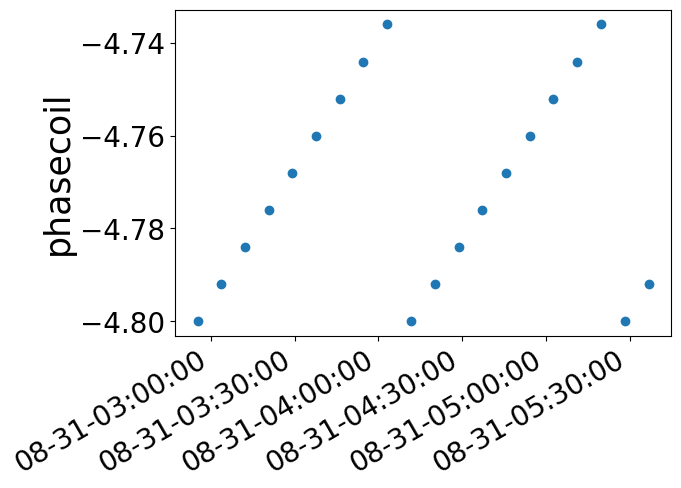

In [5]:
TIMES = []
PHASES = []
for i in range(200,220):
    _,_,t,p = spice_log_reader(i,show=False)
    PHASES.append(p['phasecoil'])
    TIMES.append(t)

fig, ax = plt.subplots()  #example of plotting with time
plt.plot(TIMES,PHASES,'o')
plt.ylabel('phasecoil')
plt.gcf().autofmt_xdate()
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%d-%H:%M:%S"))
plt.show()

## RF and phase coil parameters
***

In [5]:
GPA = 16  #Rf flipper and phase coil Gauss/amps
Phase_length = 30.  #length of phase coil (cm)
delta_RF = 8.5  #RF flipper separation (cm)
Phase_offset = 1.  #starting current of spin phase coil scan, useful for fitting procedure

_ = get_flip(Phase_length,GPA,flip=2*np.pi,show=True)

f1 = 500
f2 = 515
Lm = get_focus(f1,f2,delta=delta_RF,show=True)

Current required for a 6.28 flip: -0.05 amps
Detector distance: 287.58 cm
MIEZE frequency: 15 kHz
Modulation frequency: 30 kHz


## Data Analysis
***

***Raw Image***


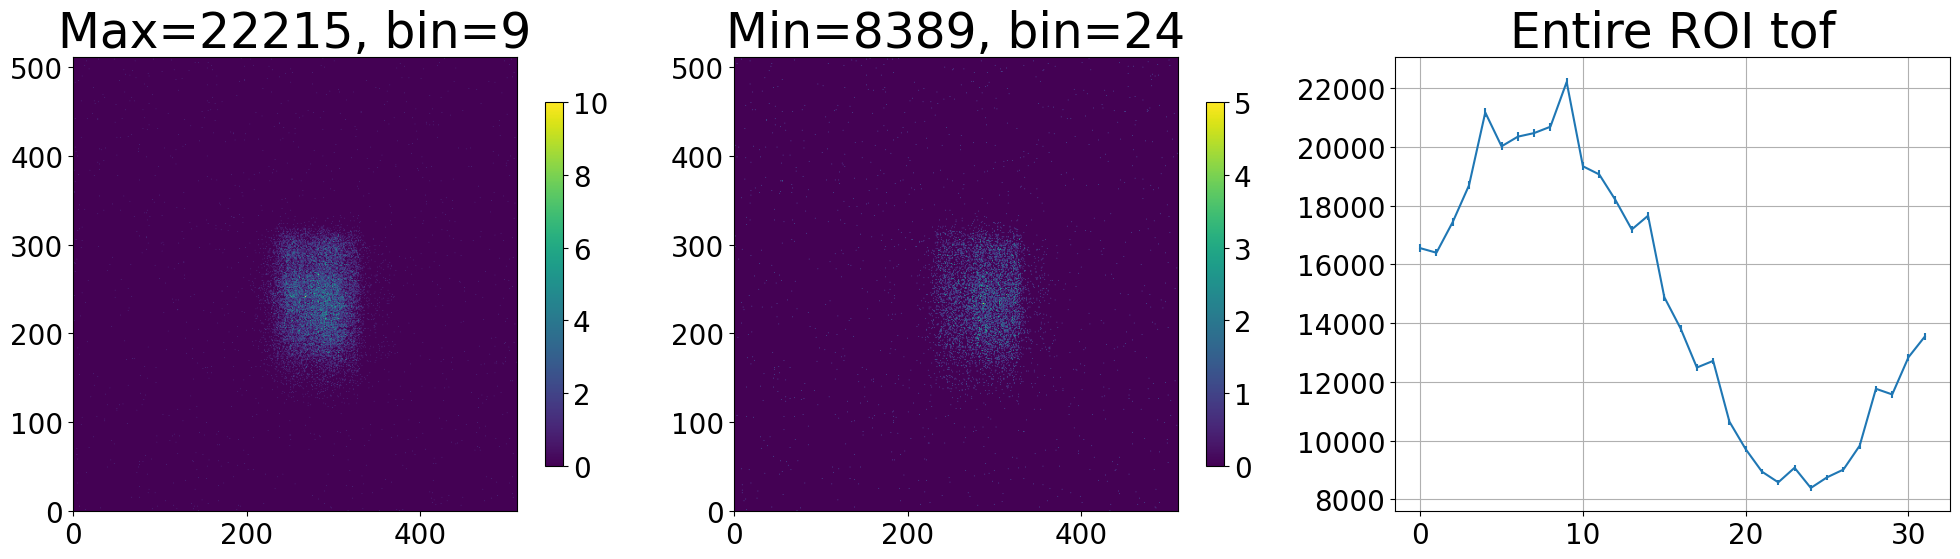

***Combined image of all subscans***


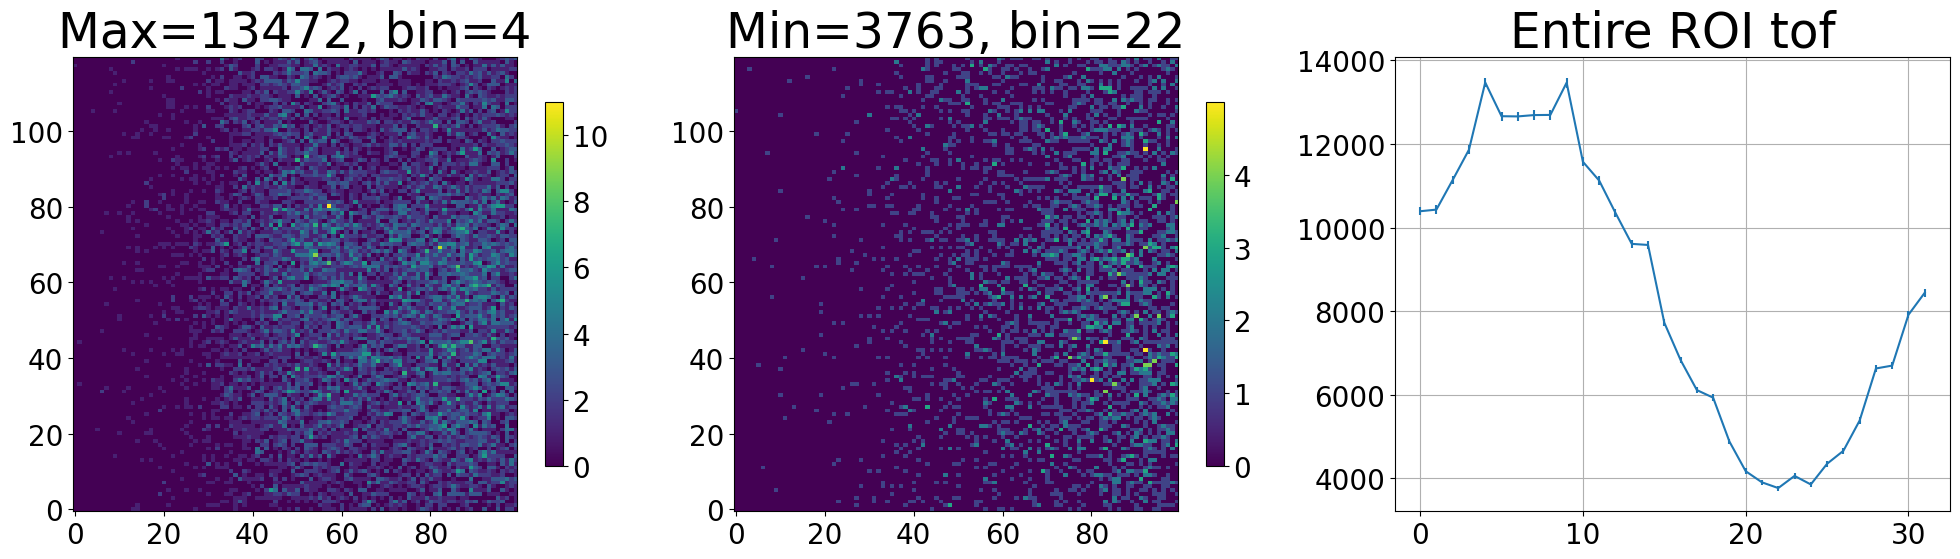

***Raw Image***


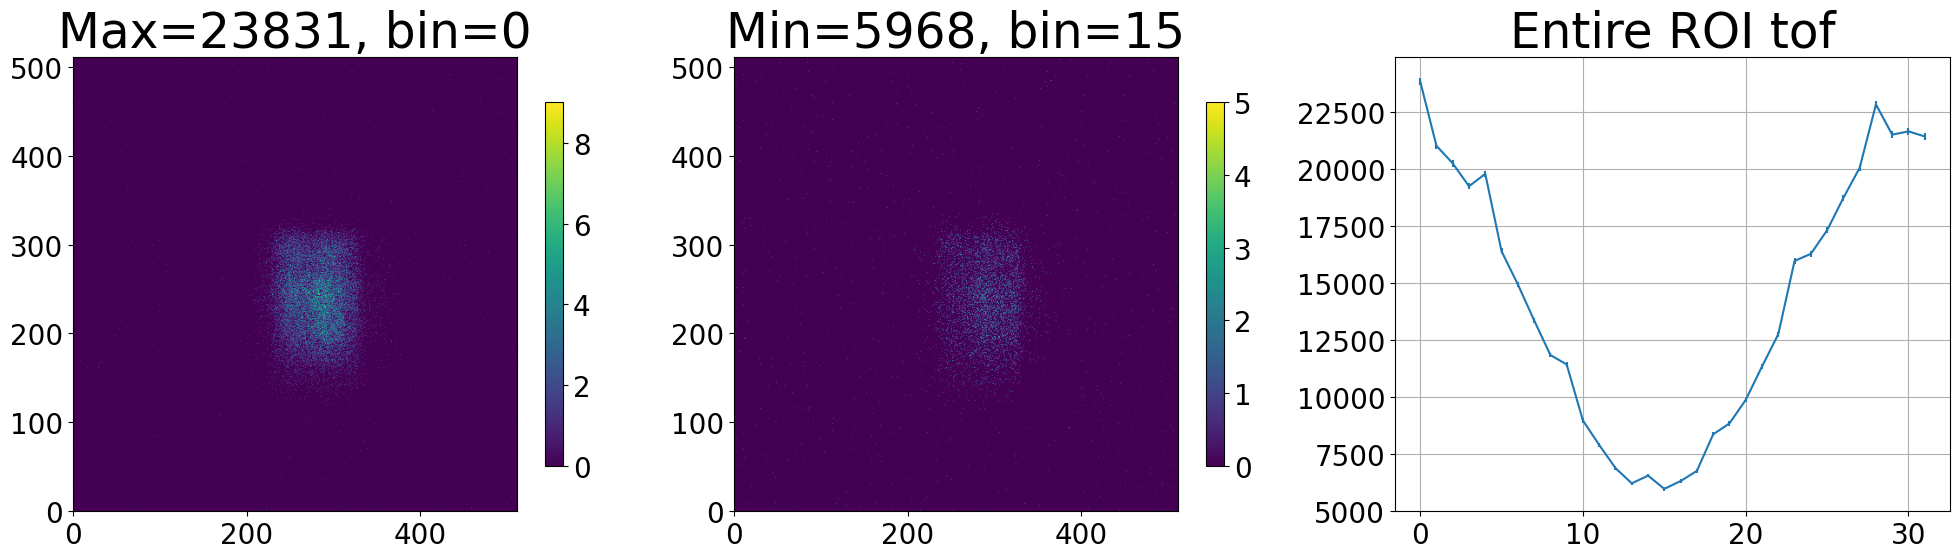

***Combined image of all subscans***


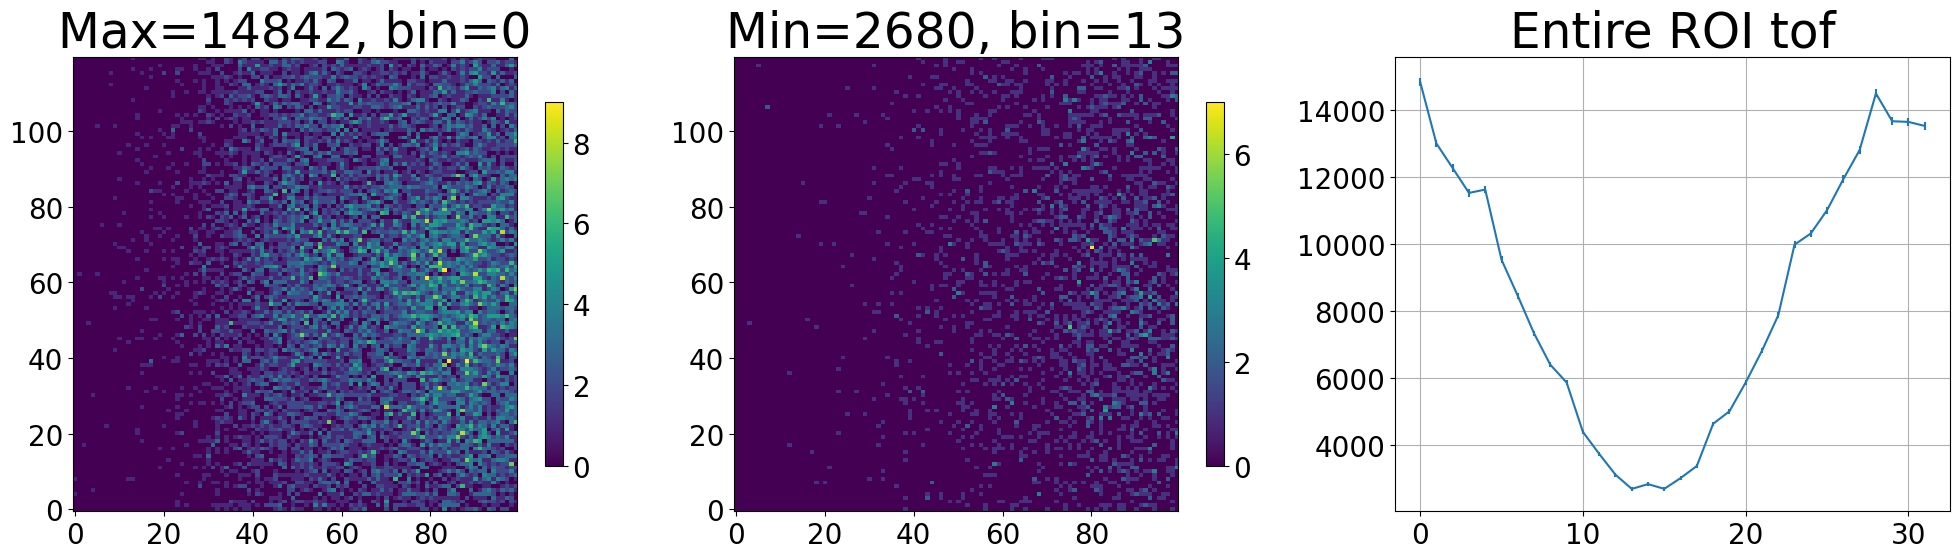

***Raw Image***


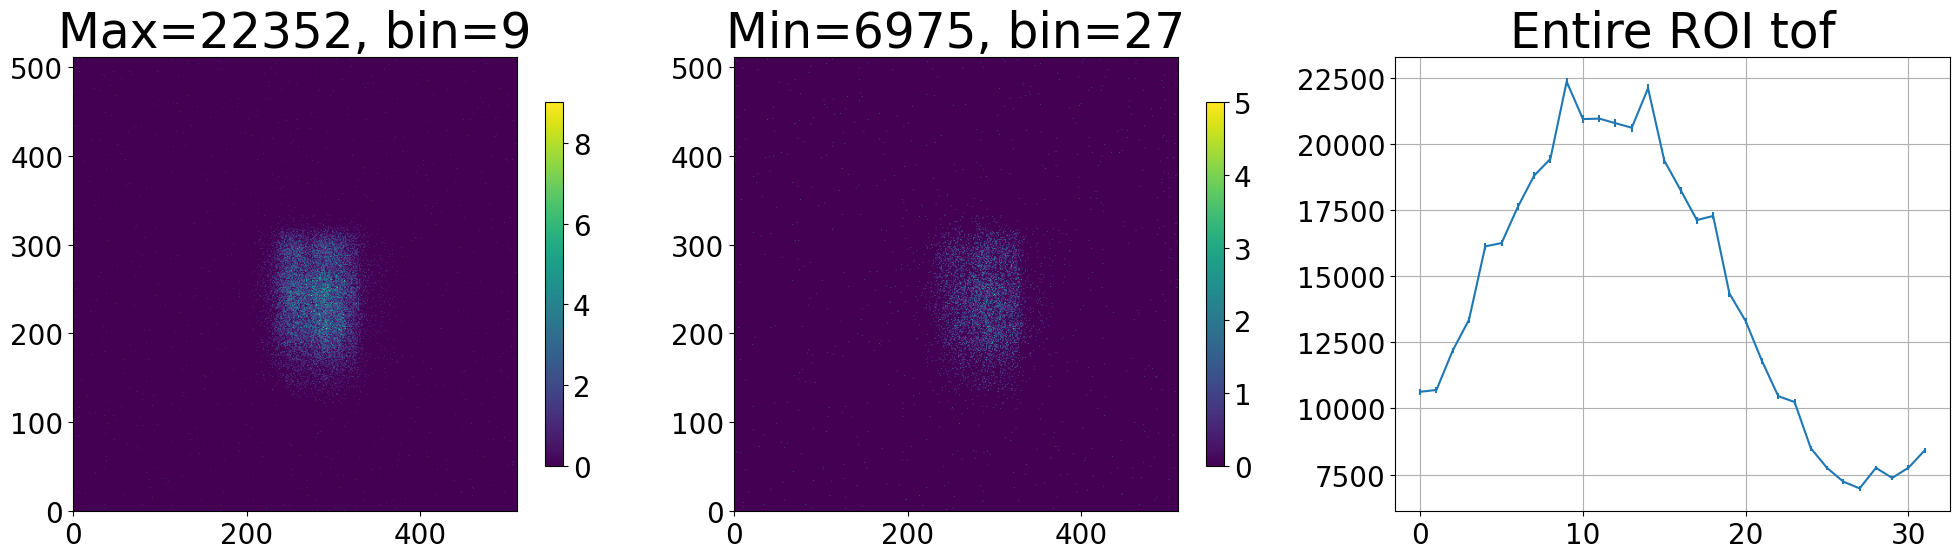

***Combined image of all subscans***


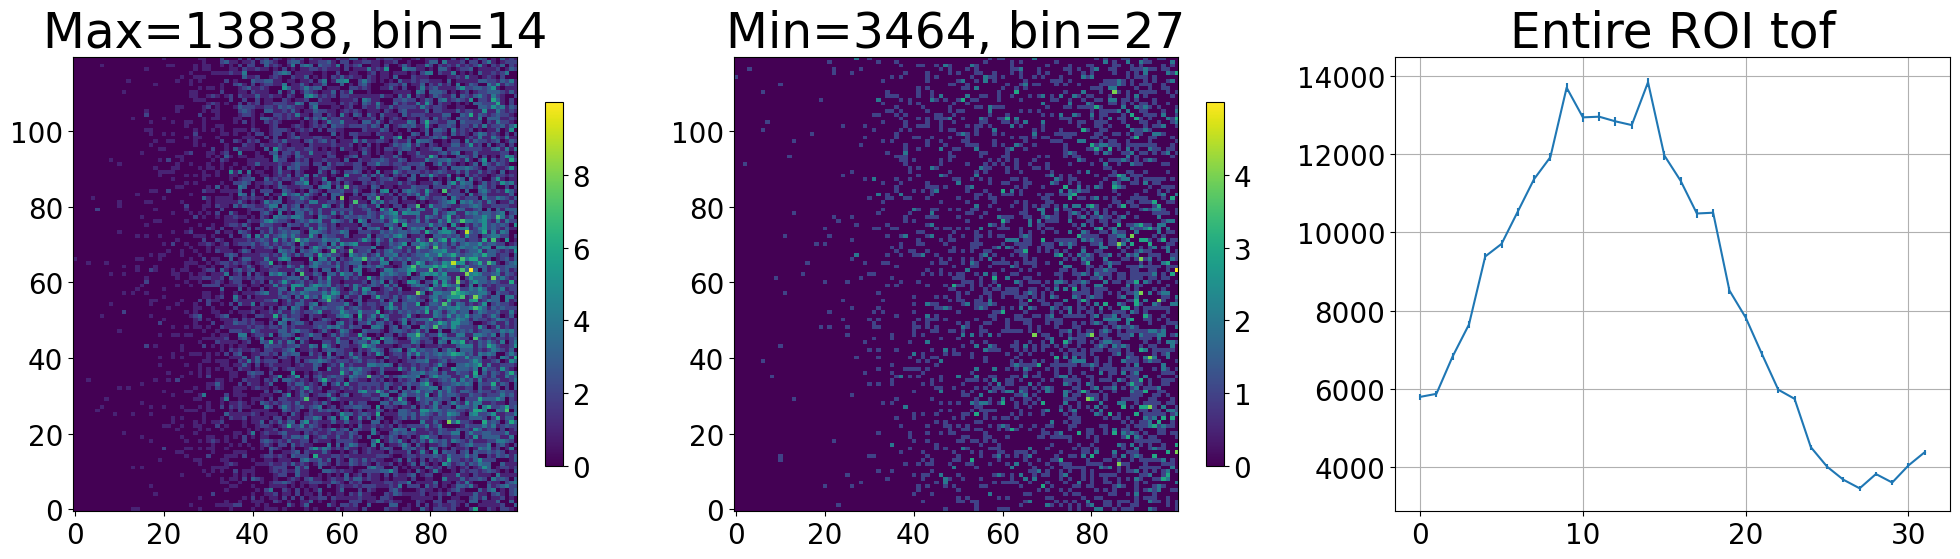

In [6]:
Rx,Ry = (200,300),(180,300)
im90 = new_reduce(90,print_raw=True,print_summed=True,ROI_x=Rx,ROI_y=Ry,direct=DEFAULT_DIRECT)
im91 = new_reduce(91,print_raw=True,print_summed=True,ROI_x=Rx,ROI_y=Ry,direct=DEFAULT_DIRECT)
im92 = new_reduce(92,print_raw=True,print_summed=True,ROI_x=Rx,ROI_y=Ry,direct=DEFAULT_DIRECT)

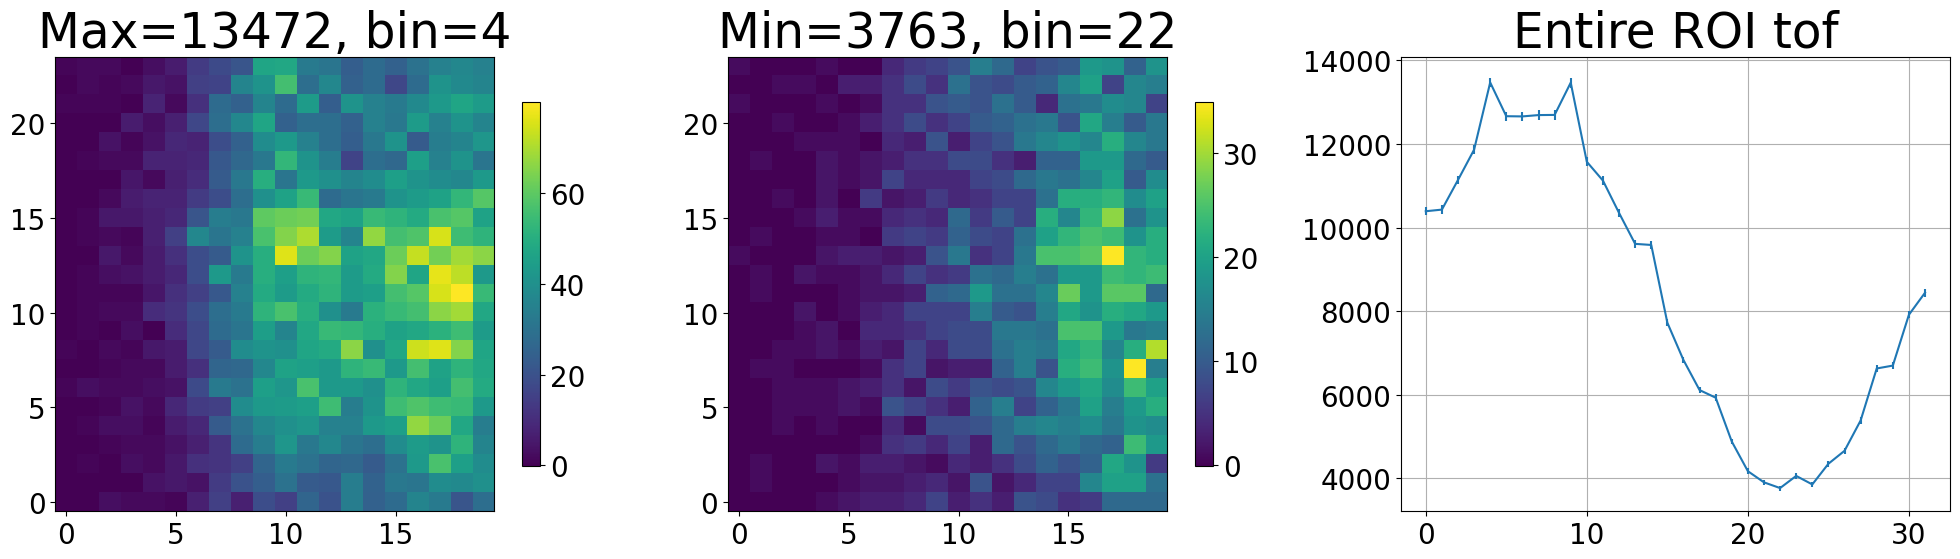

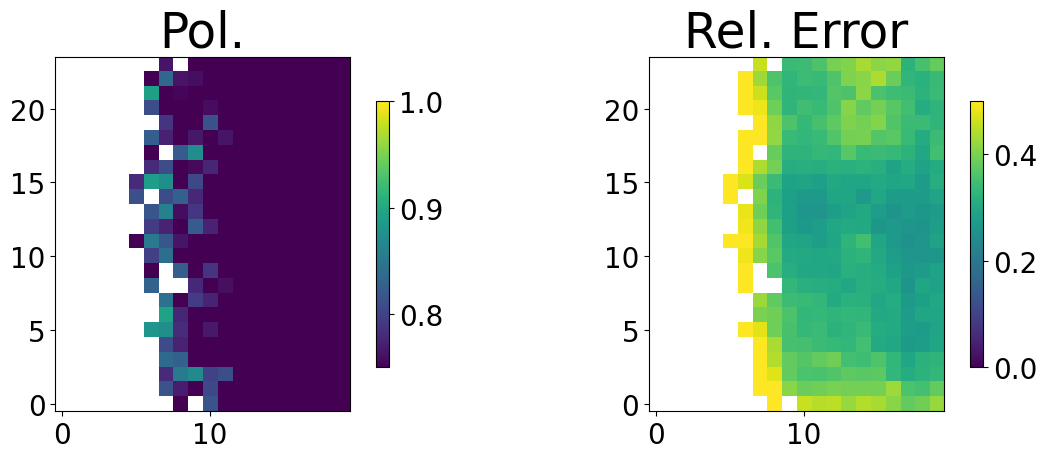

In [7]:
#_ = get_tof_pol(im90,ROI_x=(0,10),ROI_y=(0,10),plot=True)
im90_rebin = rebin_tof(im90,(5,5))
#_ = get_tof_pol(im90_rebin,ROI_x=(0,2),ROI_y=(0,2),plot=True)

fits,_ = mega_fit(im90_rebin,error_max=.5,show_contextual=True)